# RNN的优化


在线notebook：https://www.kaggle.com/code/abrahamcheng/rnn-tuning/

## 导入数据

In [1]:
import numpy as np #导入NumPy
import pandas as pd #导入Pandas 
df_app = pd.read_csv('../input/flower-app/App.csv', index_col='Date', parse_dates=['Date']) #导入数据
df_app #显示数据

,Activation
Date,
2019-01-01,419
2019-01-02,432
2019-01-03,436
2019-01-04,439
2019-01-05,439
...,...
2021-01-21,916
2021-01-22,925
2021-01-23,926


## 数据可视化


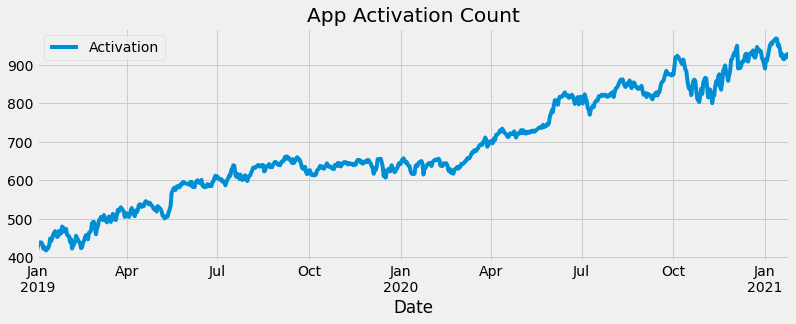

In [2]:
import matplotlib.pyplot as plt #导入matplotlib.pyplot
plt.style.use('fivethirtyeight') #设定绘图风格
df_app["Activation"].plot(figsize=(12,4),legend=True) #绘制激活数
plt.title('App Activation Count') #图题
plt.show() #绘图

## 数据清洗

In [3]:
df_app.isna().sum() #有NaN吗？

Activation    0
dtype: int64

In [4]:
(df_app.Activation < 0).values.any() #有负值吗？

False

## 拆分数据集

In [5]:
# 按照2020年10月1日为界拆分数据集
Train = df_app[:'2020-09-30'].iloc[:,0:1].values #训练集
Test = df_app['2020-10-01':].iloc[:,0:1].values #测试集

In [6]:
#Train #显示训练集对象

In [7]:
print('训练集的形状是：', Train.shape)
print('测试集的形状是：', Test.shape)

训练集的形状是： (639, 1)
测试集的形状是： (117, 1)


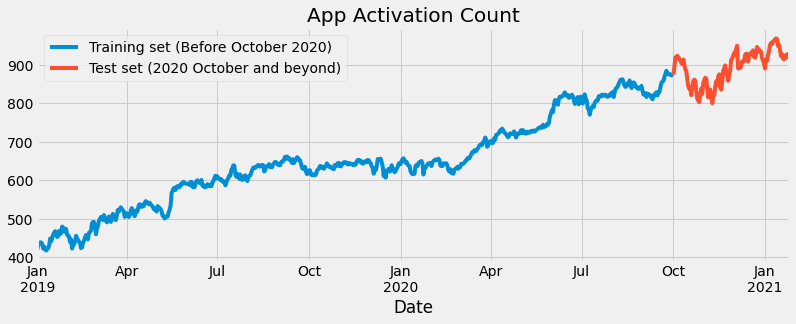

In [8]:
# 以不同颜色为训练集和测试集绘图
df_app["Activation"][:'2020-09-30'].plot(figsize=(12,4),legend=True) #训练集
df_app["Activation"]['2020-10-01':].plot(figsize=(12,4),legend=True) #测试集
plt.legend(['Training set (Before October 2020)','Test set (2020 October and beyond)']) #图例
plt.title('App Activation Count') #图题
plt.show() #绘图

## 特征工程

In [9]:
from sklearn.preprocessing import MinMaxScaler #导入归一化缩放器
Scaler = MinMaxScaler(feature_range=(0,1)) #创建缩放器
Train = Scaler.fit_transform(Train) #拟合缩放器并对训练集进行归一化

## 构建特征集和标签集

In [10]:
# 创建具有 60 个时间步长和 1 个输出的数据结构 - 训练集
X_train = [] #初始化
y_train = [] #初始化
for i in range(60,Train.size): 
    X_train.append(Train[i-60:i,0]) #构建特征
    y_train.append(Train[i,0]) #构建标签
X_train, y_train = np.array(X_train), np.array(y_train) #转换为NumPy数组
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1)) #转换成神经网络所需的张量形状

In [11]:
X_train.shape #X_train的形状

(579, 60, 1)

In [12]:
TrainTest = df_app["Activation"][:] #整体数据
inputs = TrainTest[len(TrainTest)-len(Test) - 60:].values #Test加上前60个时间步
inputs = inputs.reshape(-1,1) #转换形状
inputs  = Scaler.transform(inputs) #归一化
# 创建具有 60 个时间步长和 1 个输出的数据结构 - 测试集
X_test = [] #初始化
y_test = [] #初始化
for i in range(60,inputs.size): 
    X_test.append(inputs[i-60:i,0]) #构建特征
    y_test.append(inputs[i,0]) #构建标签
X_test = np.array(X_test) #转换为NumPy数组
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1)) #转换成神经网络所需的张量形状

In [13]:
X_test.shape #X_test的形状

(117, 60, 1)

## 选择算法

这里我们采用RNN神经网络算法

In [14]:
from tensorflow.keras.models import Sequential #导入序贯模型
from tensorflow.keras.layers import Dense, LSTM #导入全连接层和LSTM层
# from keras.optimizers import SGD
# LSTM网络架构
RNN_LSTM = Sequential() #序贯模型
RNN_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))) #输入层LSTM,return_sequences返回输出序列
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间1层LSTM，return_sequences返回输出序列
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间2层LSTM，return_sequences返回输出序列
RNN_LSTM.add(LSTM(units=50)) #中间3层LSTM
RNN_LSTM.add(Dense(units=1)) #输出层Dense
# 编译网络
RNN_LSTM.compile(loss='mse', #损失函数
                 optimizer='rmsprop', #优化器
                 metrics=['mae']) #评估指标
RNN_LSTM.summary() #输出神经网络结构信息

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 训练并保存训练历史信息
history = RNN_LSTM.fit(X_train, y_train, # 指定训练集
                  epochs=50,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_split=0.2) #这里直接从训练集数据中拆分验证集，更方便

Epoch 1/50
8/8 [==============================] - 10s 389ms/step - loss: 0.1002 - mae: 0.2616 - val_loss: 0.0976 - val_mae: 0.3092
Epoch 2/50
8/8 [==============================] - 1s 127ms/step - loss: 0.0136 - mae: 0.0946 - val_loss: 0.0036 - val_mae: 0.0490
Epoch 3/50
8/8 [==============================] - 1s 126ms/step - loss: 0.0100 - mae: 0.0859 - val_loss: 0.0058 - val_mae: 0.0636
Epoch 4/50
8/8 [==============================] - 1s 128ms/step - loss: 0.0155 - mae: 0.1021 - val_loss: 0.0143 - val_mae: 0.1104
Epoch 5/50
8/8 [==============================] - 1s 132ms/step - loss: 0.0052 - mae: 0.0577 - val_loss: 0.0043 - val_mae: 0.0534
Epoch 6/50
8/8 [==============================] - 1s 129ms/step - loss: 0.0058 - mae: 0.0617 - val_loss: 0.0704 - val_mae: 0.2614
Epoch 7/50
8/8 [==============================] - 1s 130ms/step - loss: 0.0111 - mae: 0.0916 - val_loss: 0.0121 - val_mae: 0.1002
Epoch 8/50
8/8 [==============================] - 1s 128ms/step - loss: 0.0054 - mae: 0.0

In [16]:
def show_history(history): # 显示训练过程中的学习曲线
    loss = history.history['loss'] #训练损失
    val_loss = history.history['val_loss'] #验证损失
    epochs = range(1, len(loss) + 1) #训练轮次
    plt.figure(figsize=(12,4)) # 图片大小
    plt.subplot(1, 2, 1) #子图1
    plt.plot(epochs, loss, 'bo', label='Training loss') #训练损失
    plt.plot(epochs, val_loss, 'b', label='Validation loss') #验证损失
    plt.title('Training and validation loss') #图题
    plt.xlabel('Epochs') #X轴文字
    plt.ylabel('Loss') #Y轴文字
    plt.legend() #图例
    plt.show() #绘图

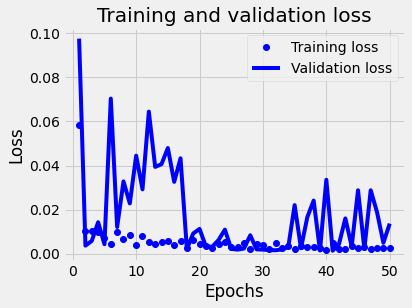

In [17]:
show_history(history) # 调用绘图函数

In [18]:
# 定义绘图函数
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Count') #真值
    plt.plot(predicted, color='blue',label='Predicted Count') #预测值
    plt.title('Flower App Activation Prediction') #图题
    plt.xlabel('Time') #X轴时间
    plt.ylabel('Flower App Activation Count') #Y轴激活数
    plt.legend() #图例
    plt.show() #绘图

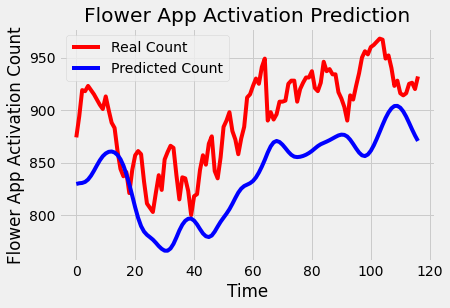

In [19]:
y_pred = RNN_LSTM.predict(X_test) #预测
Pred = Scaler.inverse_transform(y_pred) #反归一化
plot_predictions(Test,Pred) #绘图

In [20]:
# import math #导入数学函数
# 
# def return_rmse(test,predicted): #定义均方损失函数
#     rmse = math.sqrt(mean_squared_error(test, predicted)) #均方损失
#     print("MSE损失值 {}.".format(rmse))

In [21]:
from sklearn.metrics import mean_squared_error
print("调优前MSE损失值 {}.".format(mean_squared_error(y_test,y_pred)))

调优前MSE损失值 0.017648449486963674.


## 第一个调优
增加 Dropout 层

In [22]:
from tensorflow.keras.models import Sequential #导入序贯模型
from tensorflow.keras.layers import Dense, LSTM, Dropout #导入全连接层,LSTM层和Dropout层
# from keras.optimizers import SGD
# LSTM网络架构
RNN_LSTM = Sequential() #序贯模型
RNN_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))) #输入层LSTM,return_sequences返回输出序列
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间1层LSTM，return_sequences返回输出序列
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间2层LSTM，return_sequences返回输出序列
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(LSTM(units=50)) #中间3层LSTM
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(Dense(units=1)) #输出层Dense
# 编译网络
RNN_LSTM.compile(loss='mse', #损失函数
                 optimizer='rmsprop', #优化器
                 metrics=['mae']) #评估指标
RNN_LSTM.summary() #输出神经网络结构信息

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

这段代码展示了如何使用 TensorFlow 的 Keras API 创建一个包含 LSTM（长短时记忆网络）层的循环神经网络（RNN）。以下是对代码的逐行解释：

1. 导入 `Sequential` 模型，它是一个线性堆叠的神经网络层。
2. 导入 `Dense`（全连接层）、`LSTM`（长短时记忆网络）层和 `Dropout` 层，以便在创建神经网络时使用。
3. 导入优化器 `Adam`。

接下来开始构建 RNN 模型：

1. 使用 `Sequential()` 创建一个名为 `RNN_LSTM` 的空序贯模型。
2. 放入第一个 LSTM 层，其中有 50 个神经元。通过设置 `return_sequences=True`，使得 LSTM 层输出一个序列，以便在之后的层中继续建立循环神经网络。`input_shape` 设置为 `(X_train.shape[1], 1)`，表示输入的时间步长和特征维度。
3. 添入一个 Dropout 层，置丢弃率为 0.2，用于减少过拟合。
4. 接着是添加第二个 LSTM 层和 Dropout 层。此 LSTM 层也有 50 个神经元，并将 `return_sequences=True` 设置为，使 LSTM 的输出能被下一层 LSTM 继续使用。Dropout 层的丢弃比例仍为 0.2。
5. 类似地，再依次添加第三个 LSTM 层和 Dropout 层。第三个 LSTM 层和第二层配置相同，同样有 50 个神经元，且 `return_sequences=True`。 Dropout 层的丢弃比例为 0.2。
6. 再添加第四个 LSTM 层及 Dropout 层。这个 LSTM 层也有 50 个神经元，但未设置 `return_sequences=True`，因为这是最后一个 LSTM 层。Dropout 层的丢弃比例为 0.2。
7. 最后，添加一个全连接层（Dense），该层有 1 个输出单元，即预测值。

接下来，编译神经网络：

1. 使用 `compile()` 方法对网络进行编译。设置损失函数为均方误差（MSE），优化器为 RMSprop，评估指标为平均绝对误差（MAE）。

最后，调用 `RNN_LSTM.summary()` 输出网络的结构信息，以确认已正确搭建模型。

此模型可用于时间序列预测、序列生成等任务，在训练数据后，可以用来预测未来的数据。

Epoch 1/50
8/8 [==============================] - 9s 345ms/step - loss: 0.1109 - mae: 0.2870 - val_loss: 0.0386 - val_mae: 0.1910
Epoch 2/50
8/8 [==============================] - 1s 138ms/step - loss: 0.0066 - mae: 0.0629 - val_loss: 0.0053 - val_mae: 0.0598
Epoch 3/50
8/8 [==============================] - 1s 130ms/step - loss: 0.0099 - mae: 0.0809 - val_loss: 0.0025 - val_mae: 0.0403
Epoch 4/50
8/8 [==============================] - 1s 131ms/step - loss: 0.0097 - mae: 0.0806 - val_loss: 0.0130 - val_mae: 0.1037
Epoch 5/50
8/8 [==============================] - 1s 134ms/step - loss: 0.0105 - mae: 0.0792 - val_loss: 0.0636 - val_mae: 0.2480
Epoch 6/50
8/8 [==============================] - 1s 133ms/step - loss: 0.0114 - mae: 0.0856 - val_loss: 0.0151 - val_mae: 0.1134
Epoch 7/50
8/8 [==============================] - 1s 133ms/step - loss: 0.0092 - mae: 0.0730 - val_loss: 0.0351 - val_mae: 0.1816
Epoch 8/50
8/8 [==============================] - 1s 132ms/step - loss: 0.0109 - mae: 0.08

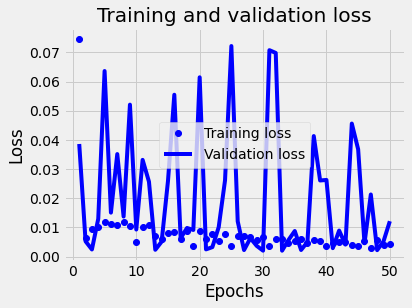

In [23]:
# 训练并保存训练历史信息
history = RNN_LSTM.fit(X_train, y_train, # 指定训练集
                  epochs=50,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_split=0.2) #这里直接从训练集数据中拆分验证集，更方便
show_history(history) # 调用绘图函数

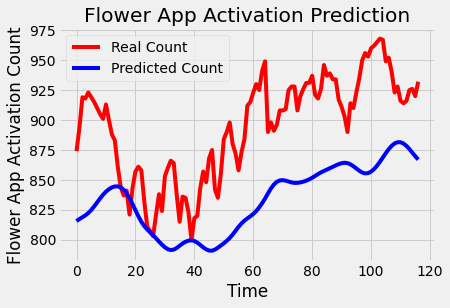

In [24]:
y_pred = RNN_LSTM.predict(X_test) #预测
Pred = Scaler.inverse_transform(y_pred) #反归一化
plot_predictions(Test,Pred) #绘图

In [25]:
print("增加Dropout层后得MSE损失值 {}.".format(mean_squared_error(y_test,y_pred)))

增加Dropout层后得MSE损失值 0.020609803699897702.


## 第二个调优

改变优化器，同时设置学习速率。

In [26]:
from tensorflow.keras.models import Sequential #导入序贯模型
from tensorflow.keras.layers import Dense, LSTM, Dropout #导入全连接层,LSTM层和Dropout层
from tensorflow.keras.optimizers import Adam
# LSTM网络架构
RNN_LSTM = Sequential() #序贯模型
RNN_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))) #输入层LSTM,return_sequences返回输出序列
RNN_LSTM.add(Dropout(0.2)) #Dropout层减少过拟合
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间层LSTM，return_sequences返回输出序列
RNN_LSTM.add(Dropout(0.2)) #Dropout层减少过拟合
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间层LSTM，return_sequences返回输出序列
RNN_LSTM.add(Dropout(0.2)) #Dropout层减少过拟合
RNN_LSTM.add(LSTM(units=50)) #中间层LSTM
RNN_LSTM.add(Dropout(0.2)) #Dropout层减少过拟合
RNN_LSTM.add(Dense(units=1)) #输出层Dense
# 编译网络
RNN_LSTM.compile(loss='mse', # 损失函数
             optimizer=Adam(lr=1e-4), # 更新优化器并设定学习速率
             metrics=['mae']) # 评估指标
RNN_LSTM.summary() #输出神经网络结构信息

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)               

这段代码和之前的一样，展示了如何使用 TensorFlow 的 Keras API 创建一个包含 LSTM（长短时记忆网络）层的循环神经网络（RNN）。唯一不同的是在编译模型时使用了 Adam 优化器并设置了一个学习速率（learning rate）。

1. 导入 `Sequential` 模型，它是一个线性堆叠的神经网络层。
2. 导入 `Dense`（全连接层）、`LSTM`（长短时记忆网络）层和 `Dropout` 层，以便在创建神经网络时使用。
3. 导入优化器 `Adam`。

接下来开始构建 RNN 模型，这部分与之前的代码相同:

1. 使用 `Sequential()` 创建一个名为 `RNN_LSTM` 的空序贯模型。
2. 放入第一个 LSTM 层，其中有 50 个神经元。通过设置 `return_sequences=True`，使得 LSTM 层输出一个序列，以便在之后的层中继续建立循环神经网络。`input_shape` 设置为 `(X_train.shape[1], 1)`，表示输入的时间步长和特征维度。
3. 添入一个 Dropout 层，置丢弃率为 0.2，用于减少过拟合。
4. 接着是添加第二个 LSTM 层和 Dropout 层。此 LSTM 层也有 50 个神经元，并将 `return_sequences=True` 设置为，使 LSTM 的输出能被下一层 LSTM 继续使用。Dropout 层的丢弃比例仍为 0.2。
5. 类似地，再依次添加第三个 LSTM 层和 Dropout 层。第三个 LSTM 层和第二层配置相同，同样有 50 个神经元，且 `return_sequences=True`。 Dropout 层的丢弃比例为 0.2。
6. 再添加第四个 LSTM 层及 Dropout 层。这个 LSTM 层也有 50 个神经元，但未设置 `return_sequences=True`，因为这是最后一个 LSTM 层。Dropout 层的丢弃比例为 0.2。
7. 最后，添加一个全连接层（Dense），该层有 1 个输出单元，即预测值。

接下来，编译神经网络：

1. 使用 `compile()` 方法对网络进行编译。设置损失函数为均方误差（MSE），优化器为 Adam，并为其设定一个学习率 `lr=1e-4`，评估指标为平均绝对误差（MAE）。

最后，调用 `RNN_LSTM.summary()` 输出网络的结构信息，以确认已正确搭建模型。

此模型可用于时间序列预测、序列生成等任务，在训练数据后，可以用来预测未来的数据。

Epoch 1/50
8/8 [==============================] - 9s 336ms/step - loss: 0.1914 - mae: 0.4180 - val_loss: 0.5524 - val_mae: 0.7418
Epoch 2/50
8/8 [==============================] - 1s 135ms/step - loss: 0.1387 - mae: 0.3536 - val_loss: 0.3985 - val_mae: 0.6297
Epoch 3/50
8/8 [==============================] - 1s 135ms/step - loss: 0.0916 - mae: 0.2828 - val_loss: 0.2205 - val_mae: 0.4675
Epoch 4/50
8/8 [==============================] - 1s 138ms/step - loss: 0.0385 - mae: 0.1758 - val_loss: 0.0556 - val_mae: 0.2313
Epoch 5/50
8/8 [==============================] - 1s 136ms/step - loss: 0.0067 - mae: 0.0625 - val_loss: 0.0027 - val_mae: 0.0427
Epoch 6/50
8/8 [==============================] - 1s 138ms/step - loss: 0.0127 - mae: 0.0921 - val_loss: 0.0099 - val_mae: 0.0886
Epoch 7/50
8/8 [==============================] - 1s 143ms/step - loss: 0.0059 - mae: 0.0603 - val_loss: 0.0316 - val_mae: 0.1716
Epoch 8/50
8/8 [==============================] - 1s 133ms/step - loss: 0.0054 - mae: 0.05

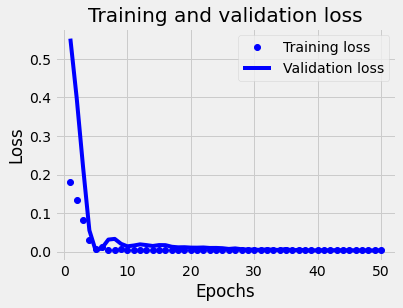

In [27]:
# 训练并保存训练历史信息
history = RNN_LSTM.fit(X_train, y_train, # 指定训练集
                  epochs=50,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_split=0.2) #这里直接从训练集数据中拆分验证集，更方便
show_history(history) # 调用绘图函数

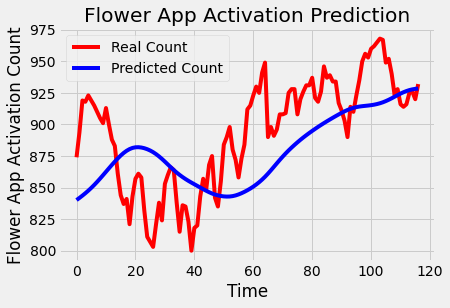

In [28]:
y_pred = RNN_LSTM.predict(X_test) #预测
Pred = Scaler.inverse_transform(y_pred) #反归一化
plot_predictions(Test,Pred) #绘图

In [29]:
print("设置优化器后的MSE损失值 {}.".format(mean_squared_error(y_test, y_pred)))

设置优化器后的MSE损失值 0.007390634852089193.
